## MDS=Multidimensional Scaling
地下鉄問題をやってみる。
http://scikit-learn.org/stable/auto_examples/manifold/plot_mds.html

Automatically created module for IPython interactive environment


/Users/matto/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:61: RuntimeWarning: divide by zero encountered in true_divide


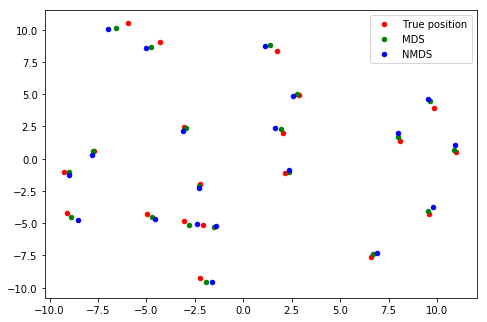

In [92]:
%matplotlib inline
#Modified from:
#http://scikit-learn.org/stable/auto_examples/manifold/plot_mds.html
# Author: Nelle Varoquaux <nelle.varoquaux@gmail.com>
# Licence: BSD

print(__doc__)
import numpy as np

from matplotlib import pyplot as plt
from matplotlib.collections import LineCollection

from sklearn import manifold
from sklearn.metrics import euclidean_distances
from sklearn.decomposition import PCA

n_samples = 20
seed = np.random.RandomState(seed=3)
X_true = seed.randint(0, 20, 2 * n_samples).astype(np.float)
X_true = X_true.reshape((n_samples, 2))
# Center the data
X_true -= X_true.mean()

similarities = euclidean_distances(X_true)

# Add noise to the similarities
noise = np.random.rand(n_samples, n_samples)
noise = noise + noise.T
noise[np.arange(noise.shape[0]), np.arange(noise.shape[0])] = 0
similarities += noise

mds = manifold.MDS(n_components=2, max_iter=3000, eps=1e-9, random_state=seed,
                   dissimilarity="precomputed", n_jobs=1)
pos = mds.fit(similarities).embedding_

nmds = manifold.MDS(n_components=2, metric=False, max_iter=3000, eps=1e-12,
                    dissimilarity="precomputed", random_state=seed, n_jobs=1,
                    n_init=1)
npos = nmds.fit_transform(similarities, init=pos)

# Rescale the data
pos *= np.sqrt((X_true ** 2).sum()) / np.sqrt((pos ** 2).sum())
npos *= np.sqrt((X_true ** 2).sum()) / np.sqrt((npos ** 2).sum())

# Rotate the data
clf = PCA(n_components=2)
X_true = clf.fit_transform(X_true)

pos = clf.fit_transform(pos)

npos = clf.fit_transform(npos)

fig = plt.figure(1)
ax = plt.axes([0., 0., 1., 1.])

plt.scatter(X_true[:, 0], X_true[:, 1], c='r', s=20)
plt.scatter(pos[:, 0], pos[:, 1], s=20, c='g')
plt.scatter(npos[:, 0], npos[:, 1], s=20, c='b')
plt.legend(('True position', 'MDS', 'NMDS'), loc='best')

similarities = similarities.max() / similarities * 100
similarities[np.isinf(similarities)] = 0


plt.show()

# 多次元構造の次元削減と可視化
個々のinherent structure は3N次元の配置空間内の点であり、それらの類似度から、近い構造同士を結びつけてネットワークを作っても、画面に表示することも直感にたよることもできない。何らかの関係性を見付けだすか、より低い次元に落とさなければ、人間は理解できない。

高次元のデータを低次元に射影することも、多変量データを少数のパラメータで表現するので、一種のモデリングと言える。

座標はわからないが、相対距離の大小関係だけがわかるような点の集合がある。これらを、与えられた次元の空間に、 相対位置関係を保ちながら点を埋めこむことを考える。

例えば、平面上の4つの点の相対距離だけがわかっているとしよう。この関係を再現するように点を3次元空間に配置すると、並進と回転の自由度を除けば点の場所は一意に決まり、点は平面上に位置する。つまり、うめこまれた空間の次元に関係なく、点は本来の次元を回復する。もし埋めこまれる空間のほうが、次元が小さい場合には、相対位置関係を完全に保ったまま埋めこむことはできず、歪みを生じる。次元を小さくしていきながら、歪みの大きさを監視すれば、点の配置に内在する実効的な空間の次元の大きさがわかるとともに、それを近似的に低次元で表示することができる。このような手法を多次元尺度法(multi-dimensional scaling, MDS)と呼ぶ。

## 例: 地下鉄料金表から路線図を推定する
[ここ](https://subway.osakametro.co.jp/guide/fare/fare/price.php)に大阪メトロの料金表がある。

https://subway.osakametro.co.jp/guide/libray/kusuuhyou/kusuuhyou20180401.pdf

地下鉄料金は駅間距離によって1区から5区に分類されている。この情報には、路線がどうつながっているかという情報は含まれていないが、各駅の間の距離は料金から逆に推定できる。

いま、この料金表しか情報がない時に、地下鉄の路線図(あるいは大阪の地図)を復元できるだろうか。

## アルゴリズム(多次元尺度法)

相対位置情報$\delta_{ij}$を維持するような、低次元(路線図の場合だと2次元、これを埋め込み空間と呼ぶ)の点$x_i$の配置を考える。

1. 埋め込み空間に、駅の数だけランダムに点$x_i$を配置する。
2. 点$x_i$と$x_j$の間の距離が$\delta_{ij}$に近づくように、ちょっとだけ点$x_i$と$x_j$を移動する。
3. すべての点の対$(i,j)$について2の作業を繰り返す。

地下鉄路線図の場合には、埋め込み次元は2次元であることが事前にわかっているが、一般にはわからない場合が多い。路線図を例えば一次元に間違ってうめこんでしまった場合、津山線ならなんとかなるが、大阪地下鉄だとどうやってもまともな解は得られない。

地下鉄の場合にも、手元にあるのは駅間の距離ではなく、区数の表だけなので、どれだけがんばっても厳密に$\delta_{ij}$を再現するような布置$\{x\}$は見付からない。

そこで、相対距離関係そのものを再現する代わりに、相対距離の*順位*を再現するように布置しよう、という考え方が生まれた。距離(計量)に依存しないので、非計量多次元尺度法(NMDS)と呼ばれる。(アルゴリズムは省略する)

## 実装


In [93]:
import numpy as np

table = np.loadtxt("blocks.txt")
stations = open("stations.txt").readlines()

In [94]:
table, table.shape

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 1.],
        [0., 0., 0., ..., 0., 1., 1.],
        ...,
        [0., 0., 0., ..., 4., 4., 4.],
        [0., 0., 1., ..., 4., 4., 4.],
        [0., 1., 1., ..., 4., 4., 5.]]), (99, 99))

表の形を整形する(上下反転し、対称化する)

In [95]:
table = table[::-1].copy()
table += table.T
noise = np.random.rand(*table.shape)
noise = noise + noise.T
noise[np.arange(noise.shape[0]), np.arange(noise.shape[0])] = 0
table += noise*0.01
table *= 100
table

array([[  0.        , 100.92789557, 101.58527829, ..., 401.29902215,
        400.63661621, 500.76477688],
       [100.92789557,   0.        , 100.77130836, ..., 400.95277023,
        400.89680754, 400.24960547],
       [101.58527829, 100.77130836,   0.        , ..., 400.63478643,
        401.31413049, 400.87527274],
       ...,
       [401.29902215, 400.95277023, 400.63478643, ...,   0.        ,
        100.61992875, 100.95335436],
       [400.63661621, 400.89680754, 401.31413049, ..., 100.61992875,
          0.        , 101.05907422],
       [500.76477688, 400.24960547, 400.87527274, ..., 100.95335436,
        101.05907422,   0.        ]])

In [96]:
len(stations)

99

In [97]:
from sklearn import manifold


mds = manifold.MDS(n_components=2, metric=True, max_iter=30000, eps=1e-12,
                    dissimilarity="precomputed", n_jobs=1,
                    n_init=1)
pos = nmds.fit(table).embedding_


nmds = manifold.MDS(n_components=2, metric=False, max_iter=3000, eps=1e-5,
                    dissimilarity="precomputed", n_jobs=1,
                    n_init=1)
npos = nmds.fit_transform(table, init=pos)


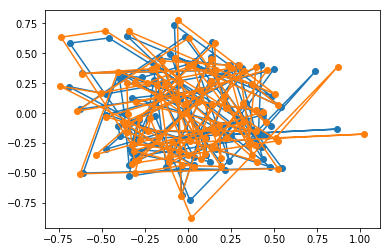

In [98]:
%matplotlib inline
from matplotlib import pyplot as plt

plt.plot(pos[:,0], pos[:,1], "o-")
plt.plot(npos[:,0], npos[:,1], "o-")